# **This is the jupyter file run in Google Colab##**

In [1]:
# Very Impoortant!!!!!!
# If you are in colab, go to Runtime ----> Change Runtime Type ----> GPU 

!pip3 install wheel==0.34.1 # by Tim Tian this is conrol the wheel.pep425tags
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)


Accelerator:  cu80


In [2]:
## by Tim G Tian during this part, choose the preprocessing.py and visualization.py together and load them
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()
                              

Saving preprocessing.py to preprocessing (1).py
Saving visualization.py to visualization (1).py


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import umap
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset
import torch.utils.data as Data
from visualization import draw_scores
from preprocessing import transfer_unit_float, normalize_channel, get_training_validation_samplers, get_priors, resize, get_transitions, serialize_object, read_pickled
# I didnt import load_data, because i need to define one to load data from gdrive

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The training will run on __ {} __'.format(device))


The training will run on __ cuda __


In [5]:
# By Tim Tian, this is for load data
ROOT_DIRECTORY = '.'
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/5328 Test Code'

def load_data(dataset_name, path='{}/data/'.format(ROOT_DIRECTORY)):
    dataset = np.load(f'{path}{dataset_name}')
    X_train, Y_train = dataset['Xtr'], dataset['Str']
    X_test, Y_test = dataset['Xts'], dataset['Yts']
    
    return X_train, Y_train, X_test, Y_test


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
########## load data ##########
mnist05_X_train, mnist05_Y_train, mnist05_X_test, mnist05_Y_test = load_data('FashionMNIST0.5.npz')
mnist06_X_train, mnist06_Y_train, mnist06_X_test, mnist06_Y_test = load_data('FashionMNIST0.6.npz')
cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test = load_data('CIFAR.npz')


########## Transfer data type and resize ##########
mnist05_X_train = resize(transfer_unit_float(mnist05_X_train))
mnist05_X_test = resize(transfer_unit_float(mnist05_X_test))
mnist06_X_train = resize(transfer_unit_float(mnist06_X_train))
mnist06_X_test = resize(transfer_unit_float(mnist06_X_test))
cifar_X_train = resize(transfer_unit_float(cifar_X_train), data_name="cifar")
cifar_X_test = resize(transfer_unit_float(cifar_X_test), data_name="cifar")


########## Preperation for train ##########
mnist05_train_set = TensorDataset(torch.from_numpy(mnist05_X_train), torch.from_numpy(mnist05_Y_train))
mnist05_test_set = TensorDataset(torch.from_numpy(mnist05_X_test), torch.from_numpy(mnist05_Y_test))

mnist06_train_set = TensorDataset(torch.from_numpy(mnist06_X_train), torch.from_numpy(mnist06_Y_train))
mnist06_test_set = TensorDataset(torch.from_numpy(mnist06_X_test), torch.from_numpy(mnist06_Y_test))

cifar_train_set = TensorDataset(torch.from_numpy(cifar_X_train), torch.from_numpy(cifar_Y_train))
cifar_test_set = TensorDataset(torch.from_numpy(cifar_X_test), torch.from_numpy(cifar_Y_test))



########## Split into trainning and validation ##########

mnist05_train_sampler, mnist05_validation_sampler = get_training_validation_samplers(mnist05_train_set)
mnist06_train_sampler, mnist06_validation_sampler = get_training_validation_samplers(mnist06_train_set)
cifar_train_sampler, cifar_validation_sampler = get_training_validation_samplers(cifar_train_set)


########## Get transitions and priors ##########
mnist05_transitions = get_transitions(data_name="mnist05")
mnist06_transitions = get_transitions(data_name="mnist06")

mnist05_priors = get_priors(mnist05_Y_test)
mnist05_noisy_priors = get_priors(mnist05_Y_train)

mnist06_priors = get_priors(mnist06_Y_test)
mnist06_noisy_priors = get_priors(mnist06_Y_train)

cifar_priors = get_priors(cifar_Y_test)
cifar_noisy_priors = get_priors(cifar_Y_train)

In [7]:
########## Different classifers: CNN, LSTM##########
class CNN(nn.Module):
    
    def __init__(self, number_classes, channel=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channel, 16, kernel_size=5, stride=1, padding=2),#1.in_channel=input height, 2.out_channel=n_filters=n_feature_map（扫描框个数）, 3.kernal_size(扫描框大小), 4.stride=1（扫描框步长）, 5.padding（图片周围填充几轮）;  28=(32-5+1)
            nn.ReLU(),
            nn.MaxPool2d(2),          #框边长为2，每2个结果输出1个，28/2 = 14，压缩后image为14*14，高度变成了16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),          #框边长为2，每2个结果输出1个，14/2 = 7，压缩后image为7*7，高度变成了32  
        )
        self.out = nn.Linear(32 * 7 * 7, number_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x



class CNN_BN(nn.Module):
    
    def __init__(self, number_classes, channel=1):
        super(CNN_BN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(channel, 16, kernel_size=5, stride=1, padding=2),#1.in_channel=input height, 2.out_channel=n_filters=n_feature_map（扫描框个数）, 3.kernal_size(扫描框大小), 4.stride=1（扫描框步长）, 5.padding（图片周围填充几轮）;  28=(32-5+1)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),          #框边长为2，每2个结果输出1个，28/2 = 14，压缩后image为14*14，高度变成了16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),          #框边长为2，每2个结果输出1个，14/2 = 7，压缩后image为7*7，高度变成了32  
        )
        self.out = nn.Linear(32 * 7 * 7, number_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

class CNN2(nn.Module): ## with Normalization on Batch

    def __init__(self, number_classes=10, channel=3):
        super(CNN2, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(channel, 32, kernel_size=5, stride=1, padding=0), # 28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # 5
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, number_classes),
        ) # No softmax because CrossEntropy loss does it.

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 5 * 5)
        x = self.classifier(x)
        return x

class CNN2_BN(nn.Module): ## with no Normalization on Batch

    def __init__(self, number_classes=10):
        super(CNN2_BN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # 5
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, number_classes),
        ) # No softmax because CrossEntropy loss does it.

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 5 * 5)
        x = self.classifier(x)
        return x
# batch_size*num_features*height*width


class LSTM(nn.Module):
    def __init__(self, number_classes=3):
        super(LSTM, self).__init__()
        self.f1 = nn.LSTM(input_size=28, hidden_size=64, num_layers=1, batch_first=False)
        self.f2 = nn.Linear(64, number_classes)
    def forward(self, x):
        r_out, (h_n, h_c) = self.f1(x.reshape(-1, 28, 28), None)
        out = self.f2(r_out[:, -1, :])#忘加f2
        return out
    
class LSTM_BN(nn.Module):
    def __init__(self, number_classes=3):
        super(LSTM_BN, self).__init__()
        self.f1 = nn.LSTM(input_size=28, hidden_size=64, num_layers=1, batch_first=False)
        self.f2 = nn.BatchNorm1d(28)
        self.f3 = nn.Linear(64, number_classes)
    def forward(self, x):
        r_out, (h_n, h_c) = self.f1(x.reshape(-1, 28, 28), None)
        r_out = self.f2(r_out)
        out = self.f3(r_out[:, -1, :])#忘加f2
        return out
    
class LSTM2(nn.Module):
    def __init__(self, number_classes=3):
        super(LSTM2, self).__init__()
        self.f1 = nn.LSTM(input_size=32 * 3, hidden_size=64, num_layers=3, batch_first=False)
        self.f2 = nn.Linear(64, number_classes)
    def forward(self, x):
        r_out, (h_n, h_c) = self.f1(x.reshape(-1, 32, 32*3), None)
        out = self.f2(r_out[:, -1, :])#忘加f2
        return out
    
class LSTM2_BN(nn.Module):
    def __init__(self, number_classes=3):
        super(LSTM2_BN, self).__init__()
        self.f1 = nn.LSTM(input_size=32 * 3, hidden_size=64, num_layers=3, batch_first=False)
        self.f2 = nn.BatchNorm1d(32)
        self.f3 = nn.Linear(64, number_classes)
    def forward(self, x):
        r_out, (h_n, h_c) = self.f1(x.reshape(-1, 32, 32*3), None)
        r_out = self.f2(r_out)
        out = self.f3(r_out[:, -1, :])#忘加f2
        return out

In [8]:
# Training and Evaluation
class Evaluation(object):
    
    def __init__(self):
        self.loss = []
        self.accuracy = []

    
class Recordings():
    
    def __init__(self, progress_recording_frequency, evaluation_recording_frequency):
        self.progress = []
        self.evaluation = Evaluation()
        self.progress_recording_frequency = progress_recording_frequency
        self.evaluation_recording_frequency = evaluation_recording_frequency
    
    def log_progress(self, epoch, epochs, iteration, iterations):
        print(f'\n---- Epoch {epoch + 1}/{epochs}, Iteration {iteration + 1}/{iterations}')
        print('Loss : {:.4f}'.format(self.progress[-1]))

    def log_evaluation(self, epoch, epochs):
        print(f'\n----- Recording of Evaluation for epoch {epoch + 1}/{epochs}')
        print('Loss: {:.4f}, Accuracy: {:.4f}'.format(self.evaluation.loss[-1], self.evaluation.accuracy[-1]))
        
    def display(self):
        iterations_axes = [i * self.progress_recording_frequency for i in range(len(self.progress))]

        # Progress Loss
        fig, (ax1) = plt.subplots(1, 1, figsize=(9, 2))
        ax1.plot(iterations_axes, self.progress, color='darkslategray')
        fig.suptitle('Progress Loss')
        ax1.set(xlabel='Iterations', ylabel='Loss')
        plt.show()

        iterations_axes = [i * self.evaluation_recording_frequency for i in range(len(self.evaluation.loss))]

        # Evaluation Metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2))
        ax1.plot(iterations_axes, self.evaluation.loss, color='darkslategray')
        ax1.set(xlabel='Epochs', ylabel='Loss')
        ax2.plot(iterations_axes, self.evaluation.accuracy, color='darkslategray')
        ax2.set(xlabel='Epochs', ylabel='Accuracy')
        fig.suptitle('Evaluation Metrics Recording')
        plt.show()
        
    def show_loss_rmse(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2))
        loss_his = self.evaluation.loss
        rmse_his = self.evaluation.accuracy
        x_loss = range(len(loss_his))
        ax1.plot(x_loss, loss_his, label='loss', color = 'b', linewidth=3)
        ax1.set_xlabel('epoches')
        ax1.set_ylabel('loss')
        ax1.legend()

        x_rmse = range(len(rmse_his))
        ax2.plot(x_rmse, rmse_his, label='rmse', color = 'r', linewidth=3)
        ax2.set_xlabel('epoches')
        ax2.set_ylabel('rmse')
        ax2.legend()
        
        plt.show()
        
def evaluate(model, loader, device, validation=False):
    # Eval flag
    model.eval()

    # Initialize metrics
    loss = 0.
    accuracy = 0.
    
    # Criterion
    criterion = nn.CrossEntropyLoss()
    
    
    with torch.no_grad():
        for (inputs, labels) in loader:
            # To device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Prediction
            label_outputs = model(inputs.float())

            # Update loss
            loss += criterion(label_outputs, labels).data.item()

            # Update Accuracies
            predicted_labels = label_outputs.data.max(1)[1]
            accuracy += predicted_labels.eq(labels.data).sum().item()

    # Average metrics
    loss /= len(loader)
    if validation:        
        accuracy /= len(loader.sampler.indices)
    else:
        accuracy /= len(loader.dataset)

    return loss, accuracy

In [9]:
def train(model, optimizer, criterion, dataset, device, params, test_loader, transition_matrix=None, verbose=False):
    print("Training by 10-fold and repeat with 10 epoches.....")
    model.to(device)
    if verbose:
        print('==== Start Training ====')
    # Train Flag
    model.train()
    
    # Recordings
    recordings = Recordings(params.log_progress_every, params.evaluate_model_every)

    # Number of classes
    nbr_classes = len(set(dataset.tensors[1].numpy()))

    # Type casting for inverse transition matrix
    if transition_matrix is not None:
        transition_matrix = transition_matrix.float()
    
    for epoch in range(params.epochs):
        model.train() # by Tim G Tian Cudnn RNN backward can only be called in training mode

        # For shuffling, regenerate the dataloaders
        t_sampler, v_sampler = get_training_validation_samplers(dataset)
        t_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=t_sampler)
        v_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=v_sampler)
        
        for iteration, (inputs, labels) in enumerate(t_loader):
            # Prepare to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reset grad
            optimizer.zero_grad()

            # Outputs
            output_labels = model(inputs.float())

            # Loss
            if transition_matrix is not None:
                unique_labels = [c * torch.ones(labels.size()[0]).long().to(device) for c in range(nbr_classes)]
                losses = [criterion(output_labels, l) for l in unique_labels]
                losses = torch.stack(losses)
                corrected_losses = losses.transpose(0,1)@transition_matrix
                loss = corrected_losses.gather(1, labels.view(-1,1)).mean()
            else:
                loss = criterion(output_labels, labels).mean()

            # Optimize
            loss.backward()
            optimizer.step()
            
            # =======
            # Log Progress
            if ((iteration + 1) % params.log_progress_every == 0):
                recordings.progress.append(loss.data.item())
                if verbose:
                    recordings.log_progress(epoch, params.epochs, iteration, len(t_loader))
        
        # Evaluate
        if ((epoch + 1) % params.evaluate_model_every == 0):
            evaluation_loss, evaluation_accuracy = evaluate(model, test_loader, device, validation=False)
            recordings.evaluation.loss.append(evaluation_loss); recordings.evaluation.accuracy.append(evaluation_accuracy)

            if verbose:
                recordings.log_evaluation(epoch, params.epochs)

        # Save temporary model
        if ((epoch + 1) % params.save_model_every == 0):
            torch.save(model.state_dict(), params.model_filename)
    
    # Save final model
    torch.save(model.state_dict(), params.model_filename)

    # Save recordings
    serialize_object(recordings, params.recordings_filename)

    if verbose:
        print('==== End Training ====')
    
    return model, recordings
        

In [10]:
class Params(object):
    ROOT_DIRECTORY = '/content/gdrive/My Drive/5328 Test Code'
    batch_size = 252
    epochs = 10
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 0
    
    log_progress_every = 50 # in iterations
    evaluate_model_every = 1 # in epochs

    save_model_every = 25 # in epochs
    model_filename = '{}/saves/model.pth'.format(ROOT_DIRECTORY)
    recordings_filename = '{}/saves/recordings.pickle'.format(ROOT_DIRECTORY)

def select_train(data_name='mnist05', classifer="cnn", optimizer_name='sgd', loss='crossentropy', estimation=True):
    params = Params()
    print(params.model_filename)
    
    if classifer == 'cnn':
        model = CNN(number_classes=3)
        model.to(device)
    elif classifer == 'cnn-bn':
        model = CNN_BN(number_classes=3)
        model.to(device)
    elif classifer == 'cnn2':
        model = CNN2(number_classes=3)
        model.to(device)
    elif classifer == 'cnn2-bn':
        model = CNN2_BN(number_classes=3)
        model.to(device)
    elif classifer == 'lstm':
        model = LSTM(number_classes=3)
        model.to(device)
    elif classifer == 'lstm-bn':
        model = LSTM_BN(number_classes=3)
        model.to(device)
    elif classifer == 'lstm2':
        model = LSTM2(number_classes=3)
        model.to(device) 
    elif classifer == 'lstm2-bn':
        model = LSTM2_BN(number_classes=3)
        model.to(device) 
    else:
        print('Wrong name of classifer.')
        return
    
    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay) # by tim g tian remove momentum
    else:
        print("Wrong name of optimizer.")
        return
    criterion = nn.CrossEntropyLoss(reduction='none')   
    
    ########## Wrap data with loader ##########
    mnist05_train_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_train_sampler)
    mnist05_validation_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_validation_sampler)
    mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=params.batch_size, shuffle=False)

    mnist06_train_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_train_sampler)
    mnist06_validation_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_validation_sampler)
    mnist06_test_loader = DataLoader(mnist06_test_set, batch_size=params.batch_size, shuffle=False)

    cifar_train_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_train_sampler)
    cifar_validation_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_validation_sampler)
    cifar_test_loader = DataLoader(cifar_test_set, batch_size=params.batch_size, shuffle=False)


    # ====================================
    # Choose dataset and Transition Matrix
    datasets_dict = {
        "mnist05": {
            "loaders": (mnist05_train_loader, mnist05_validation_loader, mnist05_test_loader),
            "dataset": mnist05_train_set,
            "testset": mnist05_test_set,
            "transition_matrix": torch.from_numpy(mnist05_transitions.T).to(device) # Transpose because defined differently than in lectures
            },
        "mnist06": {
            "loaders": (mnist06_train_loader, mnist06_validation_loader, mnist06_test_loader),
            "dataset": mnist06_train_set,
            "testset": mnist06_test_set,
            "transition_matrix": torch.from_numpy(mnist06_transitions.T).to(device) # Transpose because defined differently than in lectures
            },
        "cifar": {
            "loaders": (cifar_train_loader, cifar_validation_loader, cifar_test_loader),
            "dataset": cifar_train_set,
            "testset": cifar_test_set,
            "transition_matrix": torch.from_numpy(np.array(
                [[0.2796548,  0.37073188, 0.33353805],
                [0.37033914, 0.35247205, 0.28679701],
                [0.35000606, 0.27679607, 0.37966494]]
                ).T).to(device)
            },
    }


    train_loader, validation_loader, test_loader = datasets_dict[data_name]['loaders']
    dataset = datasets_dict[data_name]['dataset']
    testset = datasets_dict[data_name]['testset']

    if not estimation:
        transition_matrix = datasets_dict[data_name]['transition_matrix']
    else:
        transition_matrix = None
    
    model, recordings = train(model, optimizer, criterion, dataset, device, params, test_loader, transition_matrix=transition_matrix)
    #loss, accuracy = evaluate(model, test_loader, device) #
    return recordings

In [11]:
 def draw_scores(mean1, mean2, mean3, std1, std2, std3, title="", file=""):
    
    labels = ['CNN', 'CNN-BN', 'LSTM', 'LSTM-BN']

    x = np.arange(len(labels))  # the label locations
    y = np.arange(0, 1, 0.1)
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))#可调整柱子粗细高低
    rects1 = ax.bar(x - width, mean1, width, alpha=0.7, color='r' , yerr=std1, label='mnist05')
    rects2 = ax.bar(x, mean2, width, alpha=0.7, color='b', yerr=std2, label='mnist06')
    rects3 = ax.bar(x + width, mean3, width, alpha=0.7, color='g', yerr=std3, label='cifar')
    
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.yaxis.set_tick_params(labelsize=18)
    ax.set_ylabel('Accuracy', fontsize=18)
    ax.set_title(title, fontsize=18)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(labels,fontsize=18)
    ax.legend(loc=(0.65, 0.9))
    
    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)
        
    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)
        
    for rect in rects3:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)
    
    
    
    fig.tight_layout()
    plt.savefig(file + ".jpg")

# 1. Impact of classifers with Transitions

## 1.1 Different classifers(cnn, cnn-bn, lstm, lstm-bn) by sgd

In [12]:
mean1, mean2, mean3 = [], [], []
std1, std2, std3 = [], [], []

### 1.1.1 with T

In [13]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn

In [14]:
for i, classifer in enumerate(classifer_dict):
    print(classifer)
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))

cnn
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.347667 | Std of Accuracy: 0.022226 | Max of Accuracy: 0.407667 | Min of Accuracy: 0.326667
cnn-bn
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.756233 | Std of Accuracy: 0.113938 | Max of Accuracy: 0.887667 | Min of Accuracy: 0.465333
lstm
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.721267 | Std of Accuracy: 0.044667 | Max of Accuracy: 0.757333 | Min of Accuracy: 0.609667
lstm-bn
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.706333 | Std of Accuracy: 0.026861 | Max of Accuracy: 0.735667 | Min of Accuracy: 0.643667


In [15]:
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]

In [16]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]

/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.333333 | Std of Accuracy: 0.000000 | Max of Accuracy: 0.333333 | Min of Accuracy: 0.333333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.514933 | Std of Accuracy: 0.079444 | Max of Accuracy: 0.686000 | Min of Accuracy: 0.391667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.457833 | Std of Accuracy: 0.034937 | Max of Accuracy: 0.509667 | Min of Accuracy: 0.389333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.475833 | Std of Accuracy: 0.062288 | Max of Accuracy: 0.547667 | Min of Accuracy: 0.347333


In [17]:
classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]

/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn2: | Mean of Accuracy: 0.329367 | Std of Accuracy: 0.005466 | Max of Accuracy: 0.337000 | Min of Accuracy: 0.320000
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn2-bn: | Mean of Accuracy: 0.333100 | Std of Accuracy: 0.012896 | Max of Accuracy: 0.359000 | Min of Accuracy: 0.301667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm2: | Mean of Accuracy: 0.336200 | Std of Accuracy: 0.003798 | Max of Accuracy: 0.343333 | Min of Accuracy: 0.330667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm2-bn: | Mean of Accuracy: 0.350200 | Std of Accuracy: 0.010255 | Max of Accuracy: 0.365667 | Min of Accuracy: 0.331333


In [18]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_SGD_WithT","mnist05", "minis06", "cifar"])


,Classifier_SGD_WithT,mnist05,minis06,cifar
0,CNN,0.3477±0.0222,0.3333±0.0055,0.3294±0.0055
1,CNN+BN,0.7562±0.1139,0.5149±0.0129,0.3331±0.0129
2,LSTM,0.7213±0.0447,0.4578±0.0038,0.3362±0.0038
3,LSTM+BN,0.7063±0.0269,0.4758±0.0103,0.3502±0.0103


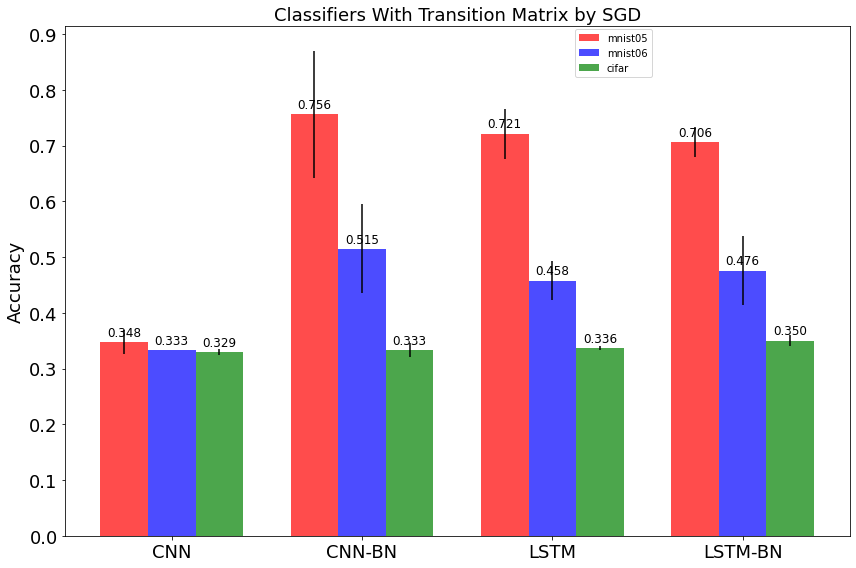

In [19]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifiers With Transition Matrix by SGD", file="classifers_with_transition_sgd")

### 1.1.2 without T

In [20]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]




classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]


classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='sgd', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]




/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.335067 | Std of Accuracy: 0.004208 | Max of Accuracy: 0.347667 | Min of Accuracy: 0.333333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.739100 | Std of Accuracy: 0.110499 | Max of Accuracy: 0.895000 | Min of Accuracy: 0.563667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.726133 | Std of Accuracy: 0.022830 | Max of Accuracy: 0.760000 | Min of Accuracy: 0.688333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.736967 | Std of Accuracy: 0.022164 | Max of Accuracy: 0.778333 | Min of Accuracy: 0.695667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat w

In [21]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_SGD_WithoutT","mnist05", "minis06", "cifar"])

,Classifier_SGD_WithoutT,mnist05,minis06,cifar
0,CNN,0.3351±0.0042,0.3333±0.0539,0.5015±0.0539
1,CNN+BN,0.7391±0.1105,0.5422±0.0363,0.4003±0.0363
2,LSTM,0.7261±0.0228,0.6486±0.0077,0.3406±0.0077
3,LSTM+BN,0.737±0.0222,0.6412±0.0052,0.332±0.0052


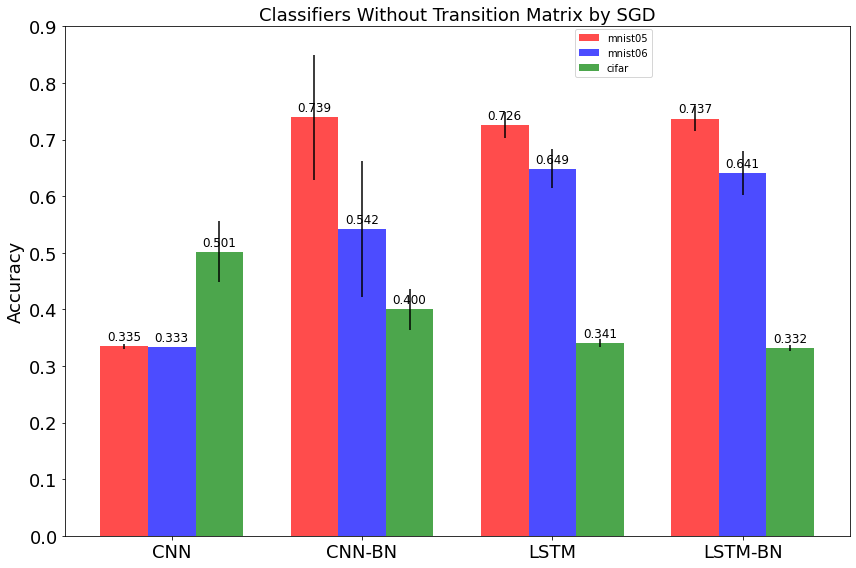

In [22]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifiers Without Transition Matrix by SGD", file="classifers_with_no_transition_sgd")

## 1.2 Different classifers(cnn, cnn-bn, lstm, lstm-bn) by RMSprop

In [23]:
mean1, mean2, mean3 = [], [], []
std1, std2, std3 = [], [], []

### 1.2.1 with T

In [24]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]




classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]


classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]




/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.343000 | Std of Accuracy: 0.017404 | Max of Accuracy: 0.372333 | Min of Accuracy: 0.314333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.691833 | Std of Accuracy: 0.111862 | Max of Accuracy: 0.833000 | Min of Accuracy: 0.448667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.527500 | Std of Accuracy: 0.106230 | Max of Accuracy: 0.651333 | Min of Accuracy: 0.333667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.477600 | Std of Accuracy: 0.124151 | Max of Accuracy: 0.686000 | Min of Accuracy: 0.331333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat w

In [25]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_RMSprop_WithT","mnist05", "minis06", "cifar"])

,Classifier_RMSprop_WithT,mnist05,minis06,cifar
0,CNN,0.343±0.0174,0.3333±0.0,0.3333±0.0
1,CNN+BN,0.6918±0.1119,0.3964±0.0,0.3333±0.0
2,LSTM,0.5275±0.1062,0.3428±0.0009,0.3339±0.0009
3,LSTM+BN,0.4776±0.1242,0.3689±0.0009,0.3352±0.0009


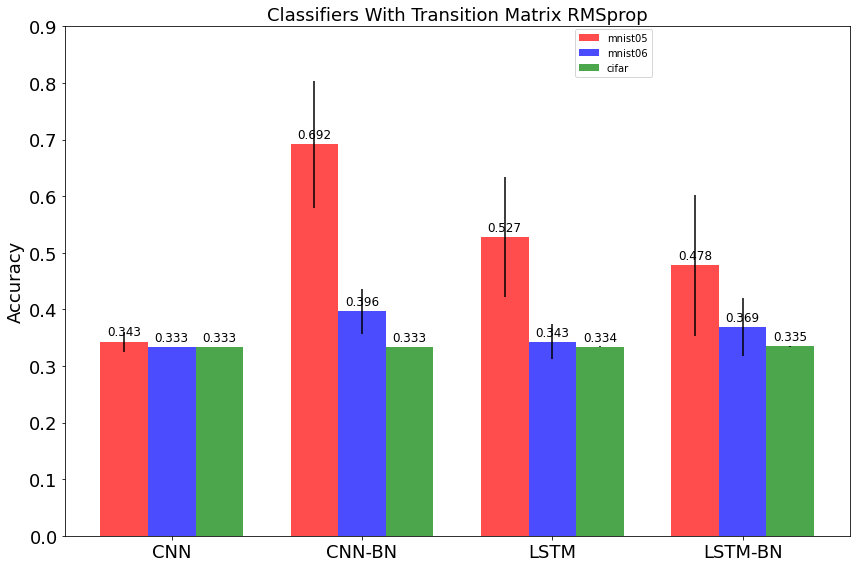

In [26]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifiers With Transition Matrix RMSprop", file="classifers_with_transition_RMS")

### 1.2.2 without T

In [27]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]




classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]


classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='rmsprop', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]



/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.332467 | Std of Accuracy: 0.004359 | Max of Accuracy: 0.339000 | Min of Accuracy: 0.325667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.713200 | Std of Accuracy: 0.116043 | Max of Accuracy: 0.864333 | Min of Accuracy: 0.486333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.528800 | Std of Accuracy: 0.109390 | Max of Accuracy: 0.721000 | Min of Accuracy: 0.344000
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.571067 | Std of Accuracy: 0.085040 | Max of Accuracy: 0.702000 | Min of Accuracy: 0.372000
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat w

In [28]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_RMSprop_WithoutT","mnist05", "minis06", "cifar"])

,Classifier_RMSprop_WithoutT,mnist05,minis06,cifar
0,CNN,0.3325±0.0044,0.3336±0.0004,0.3332±0.0004
1,CNN+BN,0.7132±0.116,0.3333±0.0001,0.3333±0.0001
2,LSTM,0.5288±0.1094,0.4292±0.0004,0.3331±0.0004
3,LSTM+BN,0.5711±0.085,0.3604±0.0005,0.3332±0.0005


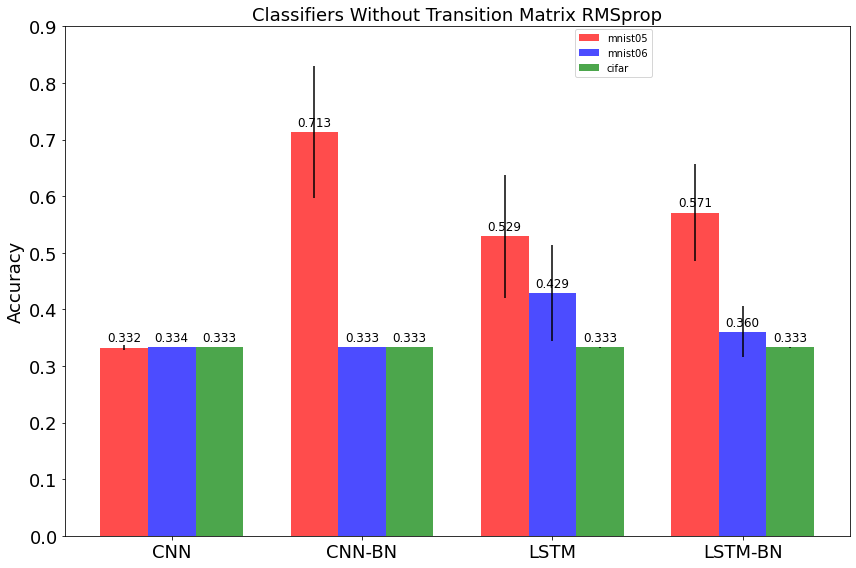

In [29]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifiers Without Transition Matrix RMSprop", file="classifers_no_transition_RMS")

## 1.3 Different classifers(cnn, cnn-bn, lstm, lstm-bn) by Adam

In [30]:
mean1, mean2, mean3 = [], [], []
std1, std2, std3 = [], [], []

### 1.3.1 with T

In [31]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]




classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]


classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=False)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]




/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.640500 | Std of Accuracy: 0.095789 | Max of Accuracy: 0.750333 | Min of Accuracy: 0.407000
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.694667 | Std of Accuracy: 0.120121 | Max of Accuracy: 0.790667 | Min of Accuracy: 0.377333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.701633 | Std of Accuracy: 0.055391 | Max of Accuracy: 0.769333 | Min of Accuracy: 0.596000
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.698567 | Std of Accuracy: 0.078370 | Max of Accuracy: 0.769333 | Min of Accuracy: 0.562333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat w

In [32]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_Adamn_WithT","mnist05", "minis06", "cifar"])

,Classifier_Adamn_WithT,mnist05,minis06,cifar
0,CNN,0.6405±0.0958,0.4259±0.0,0.3333±0.0
1,CNN+BN,0.6947±0.1201,0.4567±0.0004,0.3333±0.0004
2,LSTM,0.7016±0.0554,0.5149±0.0006,0.3333±0.0006
3,LSTM+BN,0.6986±0.0784,0.4456±0.0009,0.3335±0.0009


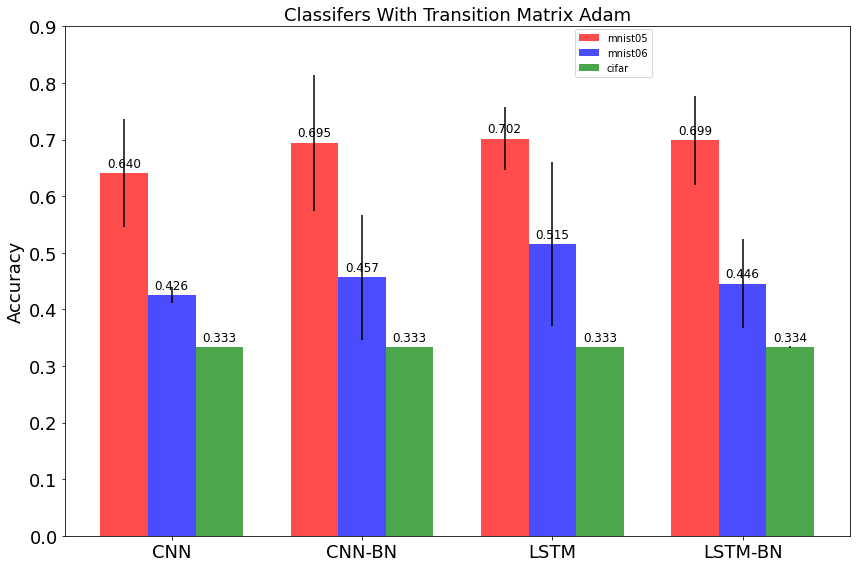

In [33]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifers With Transition Matrix Adam", file="classifers_with_transition_adam")

### 1.3.2 without T

In [34]:
classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist05', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean1 = [np.mean(accs) for accs in acc_list]
std1 = [np.std(stds) for stds in acc_list]




classifer_dict = ['cnn', 'cnn-bn', 'lstm', 'lstm-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='mnist06', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean2 = [np.mean(accs) for accs in acc_list]
std2 = [np.std(stds) for stds in acc_list]


classifer_dict = ['cnn2', 'cnn2-bn', 'lstm2', 'lstm2-bn']
acc_list = [] # [0]: cnn, [1]: cnn-bn, [2]: lstm, [4]: lstm-bn
for i, classifer in enumerate(classifer_dict):
    recordings = select_train(data_name='cifar', classifer=classifer, optimizer_name='adam', loss='crossentropy', estimation=True)
    acc_list.append(recordings.evaluation.accuracy)
    print(classifer + ': | Mean of Accuracy: {:4.6f} | Std of Accuracy: {:4.6f} | Max of Accuracy: {:4.6f} | Min of Accuracy: {:4.6f}'\
      .format(np.mean(acc_list[i]), np.std(acc_list[i]), \
              np.max(acc_list[i]), np.min(acc_list[i])))
mean3 = [np.mean(accs) for accs in acc_list]
std3 = [np.std(stds) for stds in acc_list]



/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn: | Mean of Accuracy: 0.463300 | Std of Accuracy: 0.167162 | Max of Accuracy: 0.759667 | Min of Accuracy: 0.328333
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
cnn-bn: | Mean of Accuracy: 0.849833 | Std of Accuracy: 0.062342 | Max of Accuracy: 0.912000 | Min of Accuracy: 0.725667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm: | Mean of Accuracy: 0.716167 | Std of Accuracy: 0.064959 | Max of Accuracy: 0.770000 | Min of Accuracy: 0.553667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat with 10 epoches.....
lstm-bn: | Mean of Accuracy: 0.724267 | Std of Accuracy: 0.055730 | Max of Accuracy: 0.764000 | Min of Accuracy: 0.567667
/content/gdrive/My Drive/5328 Test Code/saves/model.pth
Training by 10-fold and repeat w

In [35]:
# By Tim to get Mean +/- standard deviation


import pandas as pd
import numpy as np

mean1_std = [str(round(mu1,4)) + u"\u00B1" + str(round(std1,4)) for mu1, std1 in zip(mean1, std1)]
mean2_std = [str(round(mu2,4)) + u"\u00B1" + str(round(std2,4)) for mu2, std2 in zip(mean2, std3)]
mean3_std = [str(round(mu3,4)) + u"\u00B1" + str(round(std3,4)) for mu3, std3 in zip(mean3, std3)]

mu_std_tbl_label = ["CNN","CNN+BN", "LSTM", "LSTM+BN"]
pd.DataFrame(list(zip(mu_std_tbl_label, mean1_std,mean2_std,mean3_std)),columns=["Classifier_Adamn_WithoutT","mnist05", "minis06", "cifar"])

,Classifier_Adamn_WithoutT,mnist05,minis06,cifar
0,CNN,0.4633±0.1672,0.5456±0.0103,0.3293±0.0103
1,CNN+BN,0.8498±0.0623,0.6558±0.0004,0.3333±0.0004
2,LSTM,0.7162±0.065,0.602±0.0006,0.3334±0.0006
3,LSTM+BN,0.7243±0.0557,0.5964±0.0012,0.3323±0.0012


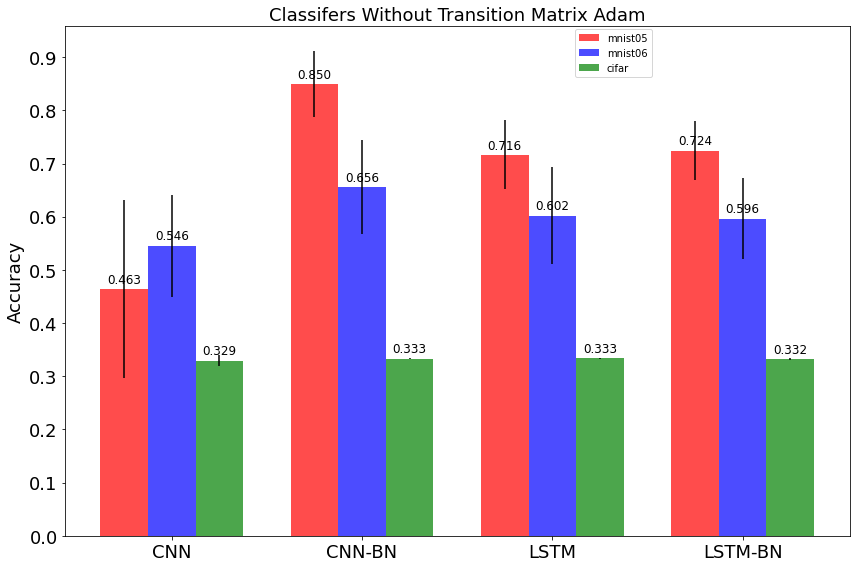

In [36]:
draw_scores(mean1, mean2, mean3, std1, std2, std3, title="Classifers Without Transition Matrix Adam", file="classifers_no_transition_adam")

In [42]:
params = Params()
########## Wrap data with loader ##########
mnist05_train_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_train_sampler)
mnist05_validation_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_validation_sampler)
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=params.batch_size, shuffle=False)

mnist06_train_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_train_sampler)
mnist06_validation_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_validation_sampler)
mnist06_test_loader = DataLoader(mnist06_test_set, batch_size=params.batch_size, shuffle=False)

cifar_train_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_train_sampler)
cifar_validation_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_validation_sampler)
cifar_test_loader = DataLoader(cifar_test_set, batch_size=params.batch_size, shuffle=False)


# ====================================
# Choose dataset and Transition Matrix
datasets_dict = {
    "mnist05": {
        "loaders": (mnist05_train_loader, mnist05_validation_loader, mnist05_test_loader),
        "dataset": mnist05_train_set,
        "testset": mnist05_test_set,
        "transition_matrix": torch.from_numpy(mnist05_transitions.T).to(device) # Transpose because defined differently than in lectures
        },
    "mnist06": {
        "loaders": (mnist06_train_loader, mnist06_validation_loader, mnist06_test_loader),
        "dataset": mnist06_train_set,
        "testset": mnist06_test_set,
        "transition_matrix": torch.from_numpy(mnist06_transitions.T).to(device) # Transpose because defined differently than in lectures
        },
    "cifar": {
        "loaders": (cifar_train_loader, cifar_validation_loader, cifar_test_loader),
        "dataset": cifar_train_set,
        "testset": cifar_test_set,
        "transition_matrix": torch.from_numpy(np.array(
            [[0.2796548,  0.37073188, 0.33353805],
            [0.37033914, 0.35247205, 0.28679701],
            [0.35000606, 0.27679607, 0.37966494]]
            ).T).to(device)
        },
}
# ==============
# Change dataset here
data_name = 'cifar'
# Change whether to train the network for transition matrix estimation
ESTIMATION = True
# ==============





if not ESTIMATION:
    transition_matrix = datasets_dict[DATASET]['transition_matrix']
else:
    transition_matrix = None

train_loader, validation_loader, test_loader = datasets_dict[data_name]['loaders']
dataset = datasets_dict[data_name]['dataset']
testset = datasets_dict[data_name]['testset']

# Note that the transition matrix estimated is actually the transpose of the transition matrix defined in report.
def estimate_transition_matrix(trained_model, train_set, test_set, device):
    
    # First, find the anchor point xi
    nbr_classes = len(set(train_set.tensors[1].numpy()))
    nbr_train_samples = len((train_set.tensors[1].numpy()))

    x_i = []
    softmax = nn.Softmax(dim=1) # Softmax needed as it is not included in the architecture
    with torch.no_grad():
        trained_model.eval()
        all_outputs_train = trained_model(train_set.tensors[0].float().to(device)).cpu().numpy()
        all_outputs_test = trained_model(test_set.tensors[0].float().to(device)).cpu().numpy()

    # Merge train set and test set to get a bigger set to draw our samples from
    all_outputs = np.concatenate((all_outputs_train, all_outputs_test))
    x_i_indices = np.argmax(all_outputs, axis=0)

    estimated_transition_matrix = np.zeros((nbr_classes,nbr_classes))
    with torch.no_grad():
        trained_model.eval()
        for i, index in enumerate(x_i_indices):
            if index < nbr_train_samples:
                p_i = softmax(trained_model(train_set.tensors[0][index].float().to(device).view(1, 3, 32, 32)))
            else:
                test_index = index - nbr_train_samples
                p_i = softmax(trained_model(train_set.tensors[0][test_index].float().to(device).view(1, 3, 32, 32)))
            estimated_transition_matrix[i,:] = p_i.cpu().numpy()[0]

    return estimated_transition_matrix

# Generalization for estimation of the transtion matrix

N = 5
ESTIMATION = True
params.epochs = 7

nbr_classes = len(set(dataset.tensors[1].numpy()))
estimates = np.zeros((N, nbr_classes, nbr_classes))
for n in range(N):
    model = CNN2(number_classes=nbr_classes).to(device).float()
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    trained_model, _ = train(model, optimizer, criterion, dataset, device, params, test_loader, transition_matrix=transition_matrix, verbose=False)
    estimates[n,:,:] = estimate_transition_matrix(trained_model, dataset, testset, device)

print('========\nEstimated Transition Matrix:\n{}\n--------\nStandard Deviation:\n{}\n========'.format(
    np.mean(estimates, axis=0), np.std(estimates, axis=0)
    )
)

Training by 10-fold and repeat with 10 epoches.....
Training by 10-fold and repeat with 10 epoches.....
Training by 10-fold and repeat with 10 epoches.....
Training by 10-fold and repeat with 10 epoches.....
Training by 10-fold and repeat with 10 epoches.....
Estimated Transition Matrix:
[[0.53298898 0.22391123 0.2430998 ]
 [0.21295191 0.52961957 0.25742853]
 [0.21647773 0.2937075  0.48981476]]
--------
Standard Deviation:
[[0.01825957 0.0566187  0.04672159]
 [0.04875406 0.03460215 0.01784053]
 [0.06048594 0.06490083 0.10339179]]
